# Applied Data Science Capstone

## Analyzing touristic attraction of major German cities

In this notebook, we will compare all major cities in Germany in terms of their attractiveness for tourists. First, we will identify the tourism-relevant venue categories reported by Foursquare. Then we will calculate the frequency of such tourist venues per city and thereby arrive at a tourism score for each city. This will help us to find the top tourist cities in Germany. We can then also cluster the cities in terms of their population size and tourist attractiveness.

### 1. Set up data frame with all major German cities and visualize them on a map

Before we can dive into the analysis, our first task is to get a list of all major German cities, including their population number and geographic coordinates. For that, we download a comprehensive list of all cities worldwide from the following website: https://simplemaps.com/data/world-cities. We then load it into a dataframe and filter for German cities with more than 100,000 inhabitants.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Worldcities.csv", usecols = ["city", "lat", "lng", "country", "population"], nrows = 5000)
df.head()

,city,lat,lng,country,population
0,Tokyo,35.6897,139.6922,Japan,37977000.0
1,Jakarta,-6.2146,106.8451,Indonesia,34540000.0
2,Delhi,28.6600,77.2300,India,29617000.0
3,Mumbai,18.9667,72.8333,India,23355000.0
4,Manila,14.5958,120.9772,Philippines,23088000.0


In [3]:
GermanCities = df[df.country == "Germany"]
GermanCities.head()

,city,lat,lng,country,population
215,Berlin,52.5167,13.3833,Germany,3644826.0
410,Hamburg,53.5500,10.0000,Germany,1841179.0
498,Munich,48.1372,11.5755,Germany,1471508.0
654,Cologne,50.9422,6.9578,Germany,1085664.0
997,Frankfurt,50.1136,8.6797,Germany,753056.0


In [4]:
GermanCities = GermanCities[GermanCities.population > 100000]
GermanCities.drop("country", axis = 1, inplace = True)
GermanCities.reset_index(inplace = True, drop = True)
GermanCities

,city,lat,lng,population
0,Berlin,52.5167,13.3833,3644826.0
1,Hamburg,53.5500,10.0000,1841179.0
2,Munich,48.1372,11.5755,1471508.0
3,Cologne,50.9422,6.9578,1085664.0
4,Frankfurt,50.1136,8.6797,753056.0
...,...,...,...,...
76,Siegen,50.8756,8.0167,102836.0
77,Hildesheim,52.1500,9.9500,101990.0
78,Gütersloh,51.9000,8.3833,100194.0
79,Cottbus,51.7606,14.3342,100219.0


Let's visualize our set of cities on a map, highlighting them based on population size.

In [5]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = "Germany")
location = geolocator.geocode("Germany")
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the center of Germany are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the center of Germany are 51.0834196, 10.4234469.


In [6]:
import folium

map_germany = folium.Map(location=[latitude, longitude], zoom_start = 6)

for lat, lng, city, pop in zip(GermanCities['lat'], GermanCities['lng'], GermanCities['city'], GermanCities['population']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    maxpop = max(df['population'])
    folium.CircleMarker(
        [lat, lng],
        radius = 15 * pop/max(GermanCities['population']),
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_germany)  
    
map_germany

### 2. Get recommended venues per city from Foursquare

Now we can start analyzing the cities in terms of their venues. For that, we need to start using Foursquare. So let's define our credentials. Personal account details were deleted from the following cell. So if you need to run the analysis yourself, just enter your own access information.

In [28]:
CLIENT_ID = 'xxx'
CLIENT_SECRET = 'xxx'
ACCESS_TOKEN = 'xxx'
VERSION = '20180605'

We want to find the top 100 venues (max) for each city within a radius of 3 km from the city center. Let's test this for the first city in our dataframe: Berlin.

In [8]:
latitude_Berlin = GermanCities.loc[0, "lat"]
longitude_Berlin = GermanCities.loc[0, "lng"]

print('Latitude and longitude values of Berlin are {}, {}.'.format(latitude_Berlin, longitude_Berlin))

Latitude and longitude values of Berlin are 52.5167, 13.3833.


In [9]:
import requests

limit = 100
radius = 3000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_Berlin, longitude_Berlin, ACCESS_TOKEN, VERSION, radius, limit)

results = requests.get(url).json()

Let's clean the JSON file and convert it to a dataframe.

In [10]:
import json
from pandas.io.json import json_normalize

venues = results["response"]["groups"][0]["items"]

recommended_venues = json_normalize(venues)
recommended_venues = recommended_venues.loc[:,["venue.name", "venue.categories", "venue.location.lat", "venue.location.lng"]]

recommended_venues.columns = ["Name", "Category", "Latitude", "Longitude"]

recommended_venues.head()

<ipython-input-10-be827e9701c2>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  recommended_venues = json_normalize(venues)


,Name,Category,Latitude,Longitude
0,Butter Lindner,"[{'id': '4bf58dd8d48988d1f5941735', 'name': 'G...",52.517879,13.380450
1,Hotel Adlon Kempinski Berlin,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",52.516038,13.380125
2,Brandenburg Gate (Brandenburger Tor),"[{'id': '4bf58dd8d48988d12d941735', 'name': 'M...",52.516247,13.377786
3,Dussmann das KulturKaufhaus,"[{'id': '4bf58dd8d48988d114951735', 'name': 'B...",52.518312,13.388708
4,Dussmann English Bookshop,"[{'id': '4bf58dd8d48988d114951735', 'name': 'B...",52.518223,13.389239


The category column needs some more work. We can create a function that extracts the category name of each venue and apply it to the data frame.

In [11]:
def get_category_type(row):
    categories_list = row["Category"]   
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]["name"]

recommended_venues["Category"] = recommended_venues.apply(get_category_type, axis = 1)

recommended_venues.head()

,Name,Category,Latitude,Longitude
0,Butter Lindner,Gourmet Shop,52.517879,13.380450
1,Hotel Adlon Kempinski Berlin,Hotel,52.516038,13.380125
2,Brandenburg Gate (Brandenburger Tor),Monument / Landmark,52.516247,13.377786
3,Dussmann das KulturKaufhaus,Bookstore,52.518312,13.388708
4,Dussmann English Bookshop,Bookstore,52.518223,13.389239


In [12]:
recommended_venues.shape

(100, 4)

Forusquare returned the maximum of 100 venues for the city of Berlin.

Now that we see that our test has worked, we can run the same analysis for all cities in our list.

In [13]:
venues_list=[]

for city, lat, lng in zip(GermanCities['city'], GermanCities['lat'], GermanCities['lng']):
    print(city)
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        lat,
        lng,
        ACCESS_TOKEN,
        VERSION,
        radius,
        limit)
            
    results = requests.get(url).json()["response"]['groups'][0]['items']
        
    venues_list.append([(
        city, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

Germany_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
Germany_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

Berlin
Hamburg
Munich
Cologne
Frankfurt
Bremen
Stuttgart
Düsseldorf
Dortmund
Essen
Dresden
Leipzig
Hannover
Nuremberg
Duisburg
Bochum
Wuppertal
Bielefeld
Bonn
Münster
Karlsruhe
Mannheim
Augsburg
Wiesbaden
Gelsenkirchen
Mönchengladbach
Kiel
Braunschweig
Aachen
Chemnitz
Halle
Magdeburg
Freiburg im Breisgau
Krefeld
Lübeck
Oberhausen
Rostock
Erfurt
Kassel
Hagen
Mainz
Saarbrücken
Hamm
Potsdam
Ludwigshafen
Mülheim
Oldenburg
Osnabrück
Leverkusen
Heidelberg
Solingen
Darmstadt
Herne
Neuss
Regensburg
Paderborn
Ingolstadt
Fürth
Würzburg
Ulm
Heilbronn
Pforzheim
Wolfsburg
Göttingen
Bottrop
Reutlingen
Koblenz
Bremerhaven
Recklinghausen
Erlangen
Bergisch Gladbach
Remscheid
Jena
Trier
Moers
Salzgitter
Siegen
Hildesheim
Gütersloh
Cottbus
Kaiserslautern


In [14]:
print(Germany_venues.shape)
Germany_venues.head()

(7493, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berlin,52.5167,13.3833,Butter Lindner,52.517879,13.380450,Gourmet Shop
1,Berlin,52.5167,13.3833,Hotel Adlon Kempinski Berlin,52.516038,13.380125,Hotel
2,Berlin,52.5167,13.3833,Brandenburg Gate (Brandenburger Tor),52.516247,13.377786,Monument / Landmark
3,Berlin,52.5167,13.3833,Dussmann das KulturKaufhaus,52.518312,13.388708,Bookstore
4,Berlin,52.5167,13.3833,Dussmann English Bookshop,52.518223,13.389239,Bookstore


Great! We now have a list of all the recommended venues for all major cities in Germany.

Let's check how many venues were returned for each city.

In [15]:
Germany_venues.groupby("City").count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Aachen,100,100,100,100,100,100
Augsburg,100,100,100,100,100,100
Bergisch Gladbach,57,57,57,57,57,57
Berlin,100,100,100,100,100,100
Bielefeld,100,100,100,100,100,100
...,...,...,...,...,...,...
Ulm,100,100,100,100,100,100
Wiesbaden,100,100,100,100,100,100
Wolfsburg,100,100,100,100,100,100


It seems that we have a very good sample to work with.

### 3. Analyze cities in terms of their touristic attractiveness

Let's see how many unique venue categories there are.

In [16]:
print('There are {} uniques categories.'.format(len(Germany_venues['Venue Category'].unique())))

There are 362 uniques categories.


And let's get a full list of these categories to decide which ones we will focus on in our analysis.

In [17]:
Germany_venues['Venue Category'].unique()

array(['Gourmet Shop', 'Hotel', 'Monument / Landmark', 'Bookstore',
       'Sandwich Place', 'Scenic Lookout', 'Capitol Building',
       'Concert Hall', 'Historic Site', 'Plaza', 'Theater', 'Supermarket',
       'Art Gallery', 'Chocolate Shop', 'Drugstore', 'Exhibit', 'Pub',
       'Outdoor Sculpture', 'Cycle Studio', 'History Museum', 'Garden',
       'Indie Theater', 'Caucasian Restaurant', 'Art Museum',
       'Rental Car Location', 'Cocktail Bar', 'Gym / Fitness Center',
       'Israeli Restaurant', 'Coffee Shop', 'Park', 'Martial Arts School',
       'Shopping Mall', 'Organic Grocery', 'Modern European Restaurant',
       'Performing Arts Venue', 'Spa', 'Middle Eastern Restaurant',
       'Poke Place', 'Café', 'Falafel Restaurant', 'Dance Studio',
       'Bistro', 'Bike Rental / Bike Share', 'Korean Restaurant',
       'Vacation Rental', 'Bakery', 'Pastry Shop', 'Deli / Bodega',
       'Japanese Restaurant', 'Beer Bar', 'Ice Cream Shop', 'Brewery',
       'Boutique', 'Escape Room

Of course, many of the categories listed here are attractive to tourists. But for simplicity and in order to be able to differentiate adequately between the cities, let's focus on four categories that seem especially relevant: 'Monument / Landmark', 'Scenic Lookout', 'Historic Site' and 'Tourist Information Center'.

One option to check for the propensity of these four categories, is to measure the frequency of each venue category in each city. So let's use one-hot encoding on the data frame containing all venues and group the dataframe by city.

In [18]:
Germany_venues_dummies = pd.get_dummies(Germany_venues[["Venue Category"]], prefix="", prefix_sep="")
Germany_venues_dummies.insert(loc = 0, column = "City", value = Germany_venues["City"])
Germany_venues_dummies

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Argentinian Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Berlin,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,Kaiserslautern,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7489,Kaiserslautern,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7490,Kaiserslautern,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7491,Kaiserslautern,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
Germany_venues_grouped = Germany_venues_dummies.groupby("City").mean().reset_index()
Germany_venues_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Argentinian Restaurant,...,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aachen,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0
1,Augsburg,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
2,Bergisch Gladbach,0.017544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
3,Berlin,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0
4,Bielefeld,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,...,0.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.01,0.0


We can now create a "Tourism Score", based on the frequency of our four selected tourism-relevant categories.

In [20]:
Germany_tourist_cities = Germany_venues_grouped[["City", "Monument / Landmark", "Scenic Lookout", "Historic Site", "Tourist Information Center"]]
Germany_tourist_cities["Tourism Score"] = Germany_tourist_cities.sum(axis = 1)
Germany_tourist_cities

<ipython-input-20-132d2b8c6c67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Germany_tourist_cities["Tourism Score"] = Germany_tourist_cities.sum(axis = 1)


,City,Monument / Landmark,Scenic Lookout,Historic Site,Tourist Information Center,Tourism Score
0,Aachen,0.00,0.00,0.00,0.0,0.00
1,Augsburg,0.00,0.00,0.02,0.0,0.02
2,Bergisch Gladbach,0.00,0.00,0.00,0.0,0.00
3,Berlin,0.03,0.01,0.03,0.0,0.07
4,Bielefeld,0.00,0.00,0.00,0.0,0.00
...,...,...,...,...,...,...
76,Ulm,0.00,0.00,0.00,0.0,0.00
77,Wiesbaden,0.00,0.00,0.00,0.0,0.00
78,Wolfsburg,0.00,0.00,0.00,0.0,0.00
79,Wuppertal,0.00,0.00,0.00,0.0,0.00


In [21]:
Germany_tourist_cities.sort_values(by = "Tourism Score", ascending = False, inplace = True)
Germany_tourist_cities = Germany_tourist_cities[["City", "Tourism Score"]]
Germany_tourist_cities

<ipython-input-21-8c5d60bd6af5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Germany_tourist_cities.sort_values(by = "Tourism Score", ascending = False, inplace = True)


,City,Tourism Score
64,Potsdam,0.08
16,Dresden,0.07
3,Berlin,0.07
75,Trier,0.05
29,Halle,0.04
...,...,...
42,Kiel,0.00
44,Krefeld,0.00
46,Leverkusen,0.00
52,Moers,0.00


Let's see which are the top 20 tourist cities in Germany, based on our analysis.

In [22]:
Germany_top_cities = Germany_tourist_cities[0:20]
Germany_top_cities

,City,Tourism Score
64,Potsdam,0.080000
16,Dresden,0.070000
3,Berlin,0.070000
75,Trier,0.050000
29,Halle,0.040000
12,Cologne,0.040000
48,Lübeck,0.040000
19,Erfurt,0.030000
6,Bonn,0.030000
33,Heidelberg,0.030000


We can now visualize these cities and their tourism score in a bar graph.

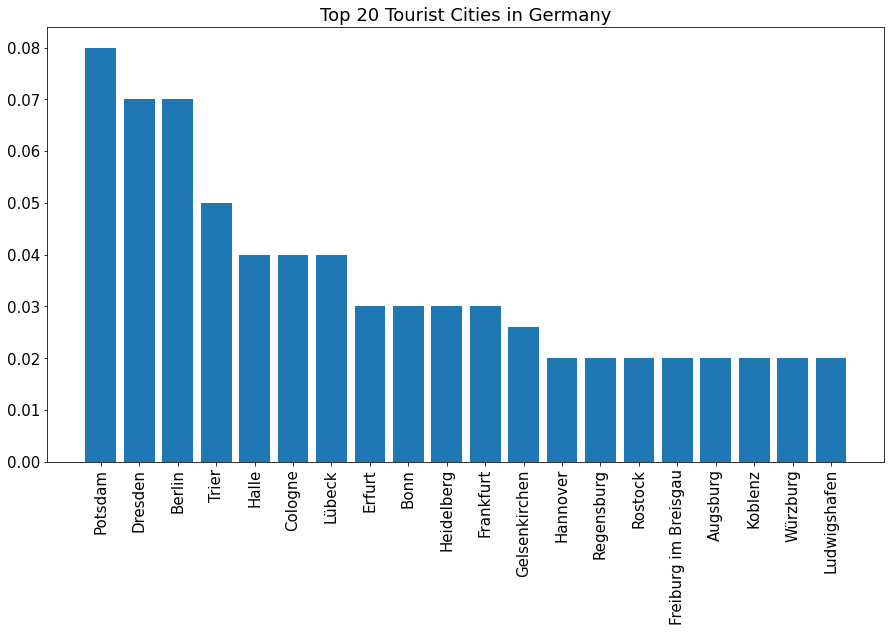

In [23]:
import matplotlib.pyplot as plt

plt.rc('font', size = 15) 
plt.figure(figsize = (15,8))
plt.bar(Germany_top_cities["City"], Germany_top_cities["Tourism Score"])
plt.xticks(rotation = 90)
plt.title("Top 20 Tourist Cities in Germany")
plt.show()

We can also visualize all major German cities on a map, with the size of their marker indicating their touristic attractiveness.

In [24]:
Germany_tourist_cities_map = Germany_tourist_cities.merge(GermanCities, left_on = "City", right_on = "city")
Germany_tourist_cities_map.drop("city", axis = 1, inplace = True)
Germany_tourist_cities_map

,City,Tourism Score,lat,lng,population
0,Potsdam,0.08,52.4000,13.0667,178089.0
1,Dresden,0.07,51.0493,13.7384,555805.0
2,Berlin,0.07,52.5167,13.3833,3644826.0
3,Trier,0.05,49.7567,6.6414,110636.0
4,Halle,0.04,51.4828,11.9697,239257.0
...,...,...,...,...,...
76,Kiel,0.00,54.3233,10.1394,247548.0
77,Krefeld,0.00,51.3333,6.5667,227020.0
78,Leverkusen,0.00,51.0333,6.9833,163838.0
79,Moers,0.00,51.4592,6.6197,103725.0


In [25]:
map_tourism = folium.Map(location=[latitude, longitude], zoom_start = 6)

for lat, lng, city, score in zip(Germany_tourist_cities_map['lat'], Germany_tourist_cities_map['lng'], Germany_tourist_cities_map['City'], Germany_tourist_cities_map['Tourism Score']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    maxscore = max(Germany_tourist_cities_map['Tourism Score'])
    folium.CircleMarker(
        [lat, lng],
        radius = 10 * score/maxscore,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_tourism)  
    
map_tourism

We can see that there are few major cities in the East of Germany. But out of those, many seem to hold a lot of promise for tourism. Especially Berlin and its neighbor city Potsdam are rich in tourist attractions.

### 4. Cluster cities in terms of population size and tourist attractiveness

Another interesting analysis could be too cluster cities in terms of their tourism attractiveness and population.

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Germany_cities_clustering = Germany_tourist_cities_map.drop(["City", "lat", "lng"], axis = 1)
Germany_cities_clustering = StandardScaler().fit_transform(Germany_cities_clustering)

kclusters = 5
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(Germany_cities_clustering)
Germany_tourist_cities_map.insert(5, "Cluster Label", kmeans.labels_)
Germany_tourist_cities_map

,City,Tourism Score,lat,lng,population,Cluster Label
0,Potsdam,0.08,52.4000,13.0667,178089.0,0
1,Dresden,0.07,51.0493,13.7384,555805.0,0
2,Berlin,0.07,52.5167,13.3833,3644826.0,2
3,Trier,0.05,49.7567,6.6414,110636.0,0
4,Halle,0.04,51.4828,11.9697,239257.0,4
...,...,...,...,...,...,...
76,Kiel,0.00,54.3233,10.1394,247548.0,1
77,Krefeld,0.00,51.3333,6.5667,227020.0,1
78,Leverkusen,0.00,51.0333,6.9833,163838.0,1
79,Moers,0.00,51.4592,6.6197,103725.0,1


In [27]:
for i in range(5):
    df_temp =  Germany_tourist_cities_map[Germany_tourist_cities_map["Cluster Label"] == i]
    df_temp.drop(["lat", "lng"], axis = 1, inplace = True)
    print(df_temp.head())
    print()

      City  Tourism Score  population  Cluster Label
0  Potsdam           0.08    178089.0              0
1  Dresden           0.07    555805.0              0
3    Trier           0.05    110636.0              0

           City  Tourism Score  population  Cluster Label
25      Cottbus       0.012821    100219.0              1
26  Bremerhaven       0.012346    113634.0              1
27   Reutlingen       0.010870    115966.0              1
28    Göttingen       0.010000    119801.0              1
29     Mannheim       0.010000    309370.0              1

     City  Tourism Score  population  Cluster Label
2  Berlin           0.07   3644826.0              2

       City  Tourism Score  population  Cluster Label
5   Cologne           0.04   1085664.0              3
30  Hamburg           0.01   1841179.0              3
36   Munich           0.01   1471508.0              3

         City  Tourism Score  population  Cluster Label
4       Halle           0.04    239257.0              4
6   

C:\Users\MoritzStumpe\anaconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\MoritzStumpe\anaconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\MoritzStumpe\anaconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\User

These clusters seem to make sense. They can be described as follows:

Cluster | Tourism Score | Population | Example
---| --- | --- | ---
0 | High | Small to Medium | Dresden
1 | Low | Small to Medium | Mannheim
2 | High | Very Large | Berlin
3 | Low to Medium | Large | Hamburg
4 | Medium | Small to Medium | Bonn

### 5. The End

This concludes our notebook. Please see my blogpost for a detailed report of this analysis:
